## Ataques de tiburones:
Vamos a determinar si el número de ataques distribuidos por decada a partir del año 1900 han ido en aumentando a lo largo del siglo. A su vez validaremos si el ataque de tiburones a mujeres también se ha incrementado desde comienzo del siglo. Y cuales suelen ser más mortales.


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

**Se ha de añadir la codificación para obtener los datos correctamente del csv. (ISO-8859-1)**

In [2]:
data = pd.read_csv('./data/GSAF5.csv', encoding='ISO-8859-1')
data.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


# Limpieza de datos
Consultamos la información del dataframe, para ver los nombre de las columnas y los tipos de datos

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 24 columns):
Case Number               5992 non-null object
Date                      5992 non-null object
Year                      5992 non-null int64
Type                      5992 non-null object
Country                   5949 non-null object
Area                      5590 non-null object
Location                  5496 non-null object
Activity                  5465 non-null object
Name                      5792 non-null object
Sex                       5425 non-null object
Age                       3311 non-null object
Injury                    5965 non-null object
Fatal (Y/N)               5973 non-null object
Time                      2779 non-null object
Species                   3058 non-null object
Investigator or Source    5977 non-null object
pdf                       5992 non-null object
href formula              5991 non-null object
href                      5989 non-null object
C

**Análisis de los valores nulos para decidir que columnas eliminar**

In [4]:
#He creado una función para poder reutilizarla posteriormente
def nulos(dataframe):
    null_cols = dataframe.isnull().sum()
    print(null_cols[null_cols > 0])
    return null_cols

null_cols = nulos(data)

Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
href formula                 1
href                         3
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


**Eliminación de las columnas con demasiados nulos y las que no vamos a utilizar en el análisis**

In [5]:
#Eliminio las columnas que tienen más de 3000 registros nulos ya que son más del 50% de los registros  
drop_cols = list(null_cols[null_cols > 3000].index)
nueva_data = data.drop(drop_cols, axis=1)


In [6]:
#También eliminio otras columnas que no voy a utilizar
nueva_data = nueva_data.drop(['Area', 'Location', 'Species ', 'Injury', 
                              'Age', 'Activity', 'Name', 'Date', 'Investigator or Source', 
                              'pdf', 'href formula', 'href', 'Case Number.1', 
                              'Case Number.2', 'original order'], axis=1)
display(nueva_data.head())
print(nueva_data.shape)

,Case Number,Year,Type,Country,Sex,Fatal (Y/N)
0,2016.09.18.c,2016,Unprovoked,USA,M,N
1,2016.09.18.b,2016,Unprovoked,USA,M,N
2,2016.09.18.a,2016,Unprovoked,USA,M,N
3,2016.09.17,2016,Unprovoked,AUSTRALIA,M,N
4,2016.09.15,2016,Unprovoked,AUSTRALIA,M,N


(5992, 6)


In [7]:
#Realizo una primera comprobación de registros duplicados
def remover_duplicados(dataframe, columnas = []):
    antes = len(dataframe)
    dataframe = dataframe[columnas].drop_duplicates()
    despues = len(dataframe)
    total = antes - despues
    print('Registros duplicados eliminados: {}'.format(total))
    return dataframe

temporal = remover_duplicados(data)

Registros duplicados eliminados: 0


In [10]:
test = nueva_data[(nueva_data['Year'] == 0)] #valores incorrectos
print(len(test))

124


In [12]:
stats = nueva_data.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']

outliers = pd.DataFrame(columns = nueva_data.columns)

for col in stats.index:
    iqr = stats.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col,'25%'] - cutoff
    upper = stats.at[col,'75%'] + cutoff
    results = nueva_data[(nueva_data[col] < lower) | 
                   (nueva_data[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)

print(len(outliers))
#print(outliers['Year'].value_counts().sort_index( ascending = False))

#Como vamos a utilizar los datos del siglo 20 estos valores seran descartados igualmente

238


**Estas son las columnas que mantendremos para el análisis**

In [13]:
#Columnas restantes
print(nueva_data.columns)
print(len(nueva_data.columns))

Index(['Case Number', 'Year', 'Type', 'Country', 'Sex ', 'Fatal (Y/N)'], dtype='object')
6


In [14]:
#Renombro varias columnas, unas porque tienen un espacio al final y otras porque contienen otros caracteres
nueva_data = nueva_data.rename(columns={'Fatal (Y/N)':'Fatal', 
                                        'Sex ':'Sex'})
print(nueva_data.columns)
print(nueva_data.shape)

Index(['Case Number', 'Year', 'Type', 'Country', 'Sex', 'Fatal'], dtype='object')
(5992, 6)


In [15]:
#Compruebo los diferentes tipos de ataque y los difrentes valores para la columan Fatal
tipos_ataque = nueva_data.Type.unique()
print(tipos_ataque)
#set(nueva_data['Type'])

nueva_data['Fatal'].value_counts()


['Unprovoked' 'Boat' 'Provoked' 'Invalid' 'Sea Disaster' 'Boating']


N          4315
Y          1552
UNKNOWN      94
 N            8
#VALUE!       1
n             1
F             1
N             1
Name: Fatal, dtype: int64

## Actualizamos los valores de varias columnas que utilizaremos posteriormente

In [18]:
#Para la columna Country asignamos el valor "Otro" a los valores nulos
nueva_data['Country'] = nueva_data['Country'].str.strip().str.upper()
nueva_data['Country'] = nueva_data['Country'].fillna('Otro')

In [19]:
print(set(nueva_data['Sex']))

# N la cambiamos por M ya que al estar la teclas tan próximas lo consideramos un error al introducir los datos
# y al ser su número reducido optamos por asignarles M

nueva_data['Sex'] = nueva_data['Sex'].str.strip().str.upper()
nueva_data['Sex'] = nueva_data['Sex'].str.replace('.', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].str.replace('N', 'M') 
nueva_data['Sex'] = nueva_data['Sex'].str.replace('LLI', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].str.replace('UMKMOWM', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].fillna('UNKNOWN')

print(set(nueva_data['Sex']))
print(nueva_data['Sex'].value_counts())

{'F', 'M', 'UNKNOWN'}
{'F', 'M', 'UNKNOWN'}
M          4838
F           585
UNKNOWN     569
Name: Sex, dtype: int64


In [20]:
#Modificamos los datos en la columna Fatal para unificarlos (N, Y, UNKNOWN)
nueva_data['Fatal'] = nueva_data['Fatal'].str.strip().str.upper()
nueva_data['Fatal'] = nueva_data['Fatal'].str.replace('#VALUE!', 'UNKNOWN')
nueva_data['Fatal'] = nueva_data['Fatal'].str.replace('F', 'UNKNOWN')

#Los valores nulos también los pasamos a UNKNOWN
nueva_data['Fatal'] = nueva_data['Fatal'].fillna('UNKNOWN')
print(set(nueva_data['Fatal']))
print(nueva_data['Fatal'].value_counts())

{'N', 'Y', 'UNKNOWN'}
N          4325
Y          1552
UNKNOWN     115
Name: Fatal, dtype: int64


In [21]:
#Comprobamos los nulos en el nuevo dataframe 
nulos(nueva_data)

Series([], dtype: int64)


Case Number    0
Year           0
Type           0
Country        0
Sex            0
Fatal          0
dtype: int64

In [22]:
#Volvemos a comprobar si hay duplicados después del cambio en la columna Fatal
print(len(nueva_data))
nueva_data = remover_duplicados(nueva_data, nueva_data.columns)
print(len(nueva_data))

5992
Registros duplicados eliminados: 4
5988


# Datos sobre los que realizaremos el estudio

### Se mostrará la evolución de los ataque de tiburón en las decadas del siglo 20

In [23]:
#Se filtran los registros entres a partir de el año 1900, los datos anteriores no los tendremos en cuenta
#Para este estudio, a su vez también descartamos los ataques clasificados como Invalid.

datos = nueva_data[(nueva_data.Year > 1900) & (nueva_data.Year <= 2000) & (nueva_data.Type != 'Invalid')]
datos = datos.sort_values(by=['Year'])
datos.head()

,Case Number,Year,Type,Country,Sex,Fatal
5311,1901.00.00,1901,Unprovoked,USA,M,N
5303,1901.12.01,1901,Unprovoked,AUSTRALIA,M,N
5304,1901.10.00,1901,Unprovoked,PHILIPPINES,M,N
5310,1901.01.30,1901,Unprovoked,AUSTRALIA,M,Y
5306,1901.07.30,1901,Unprovoked,SOUTH AFRICA,M,Y


In [24]:
#Vamos a añadir una columna de mes, esta la obtendremos de la columna "Case Number"
def obtener_mes(fecha):
    n = re.findall('[^.]+[0-9]{1}', fecha)
    return n[1]
    
    
datos['Month'] = datos['Case Number'].apply(obtener_mes) 
#Reordenamos las celdas
columnas_orden = ['Year', 'Month', 'Type', 'Fatal', 'Sex', 'Country', 'Case Number']
datos = datos[columnas_orden]
datos.head()
#datos.shape

,Year,Month,Type,Fatal,Sex,Country,Case Number
5311,1901,00,Unprovoked,N,M,USA,1901.00.00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00
5310,1901,01,Unprovoked,Y,M,AUSTRALIA,1901.01.30
5306,1901,07,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30


In [25]:
#Comprobamos los valores insertados en la columna Month además le cambiamos el tipo
datos['Month'] = datos['Month'].astype('int')
#datos['Month'].value_counts() / len(datos) * 100
datos['Month'].value_counts()

7     343
8     312
1     298
9     266
0     257
12    253
11    231
6     229
2     227
3     222
10    219
4     205
5     182
30      1
Name: Month, dtype: int64

In [26]:
#Como pudimos ver anteriormente hay demasiados meses con valor 0 y alguno con valor 30
#El de valor 30 lo descarto, pero los de valor 0 me planteo que hacer con ellos.
#Los cambiaré por el valor de la media

datos = datos[(datos.Month != 30)]

media_mes = datos['Month'].mean()

datos.loc[(datos['Month'] == 0 ), 'Month'] = int(media_mes)
datos.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number
5311,1901,6,Unprovoked,N,M,USA,1901.00.00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30


In [27]:
#Creo bins para las decadas del siglo 20
decadas = ['Años 00', 'Años 10', 'Años 20', 'Años 30', 'Años 40', 
           'Años 50', 'Años 60', 'Años 70', 'Años 80', 'Años 90']
cutoffs = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2001]

decadas_bins = pd.cut(datos['Year'], cutoffs, labels = decadas)
decadas_bins.head()

5311    Años 00
5303    Años 00
5304    Años 00
5310    Años 00
5306    Años 00
Name: Year, dtype: category
Categories (10, object): [Años 00 < Años 10 < Años 20 < Años 30 ... Años 60 < Años 70 < Años 80 < Años 90]

## Evolución de los ataques

In [28]:
datos_siglo = datos
datos_siglo['Decade'] = decadas_bins
#datos_siglo.loc[datos_siglo['Year'] == 2000].head()
datos_siglo.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number,Decade
5311,1901,6,Unprovoked,N,M,USA,1901.00.00,Años 00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01,Años 00
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00,Años 00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30,Años 00
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30,Años 00


In [29]:
decadas_graf = datos_siglo.Decade.value_counts().sort_index()

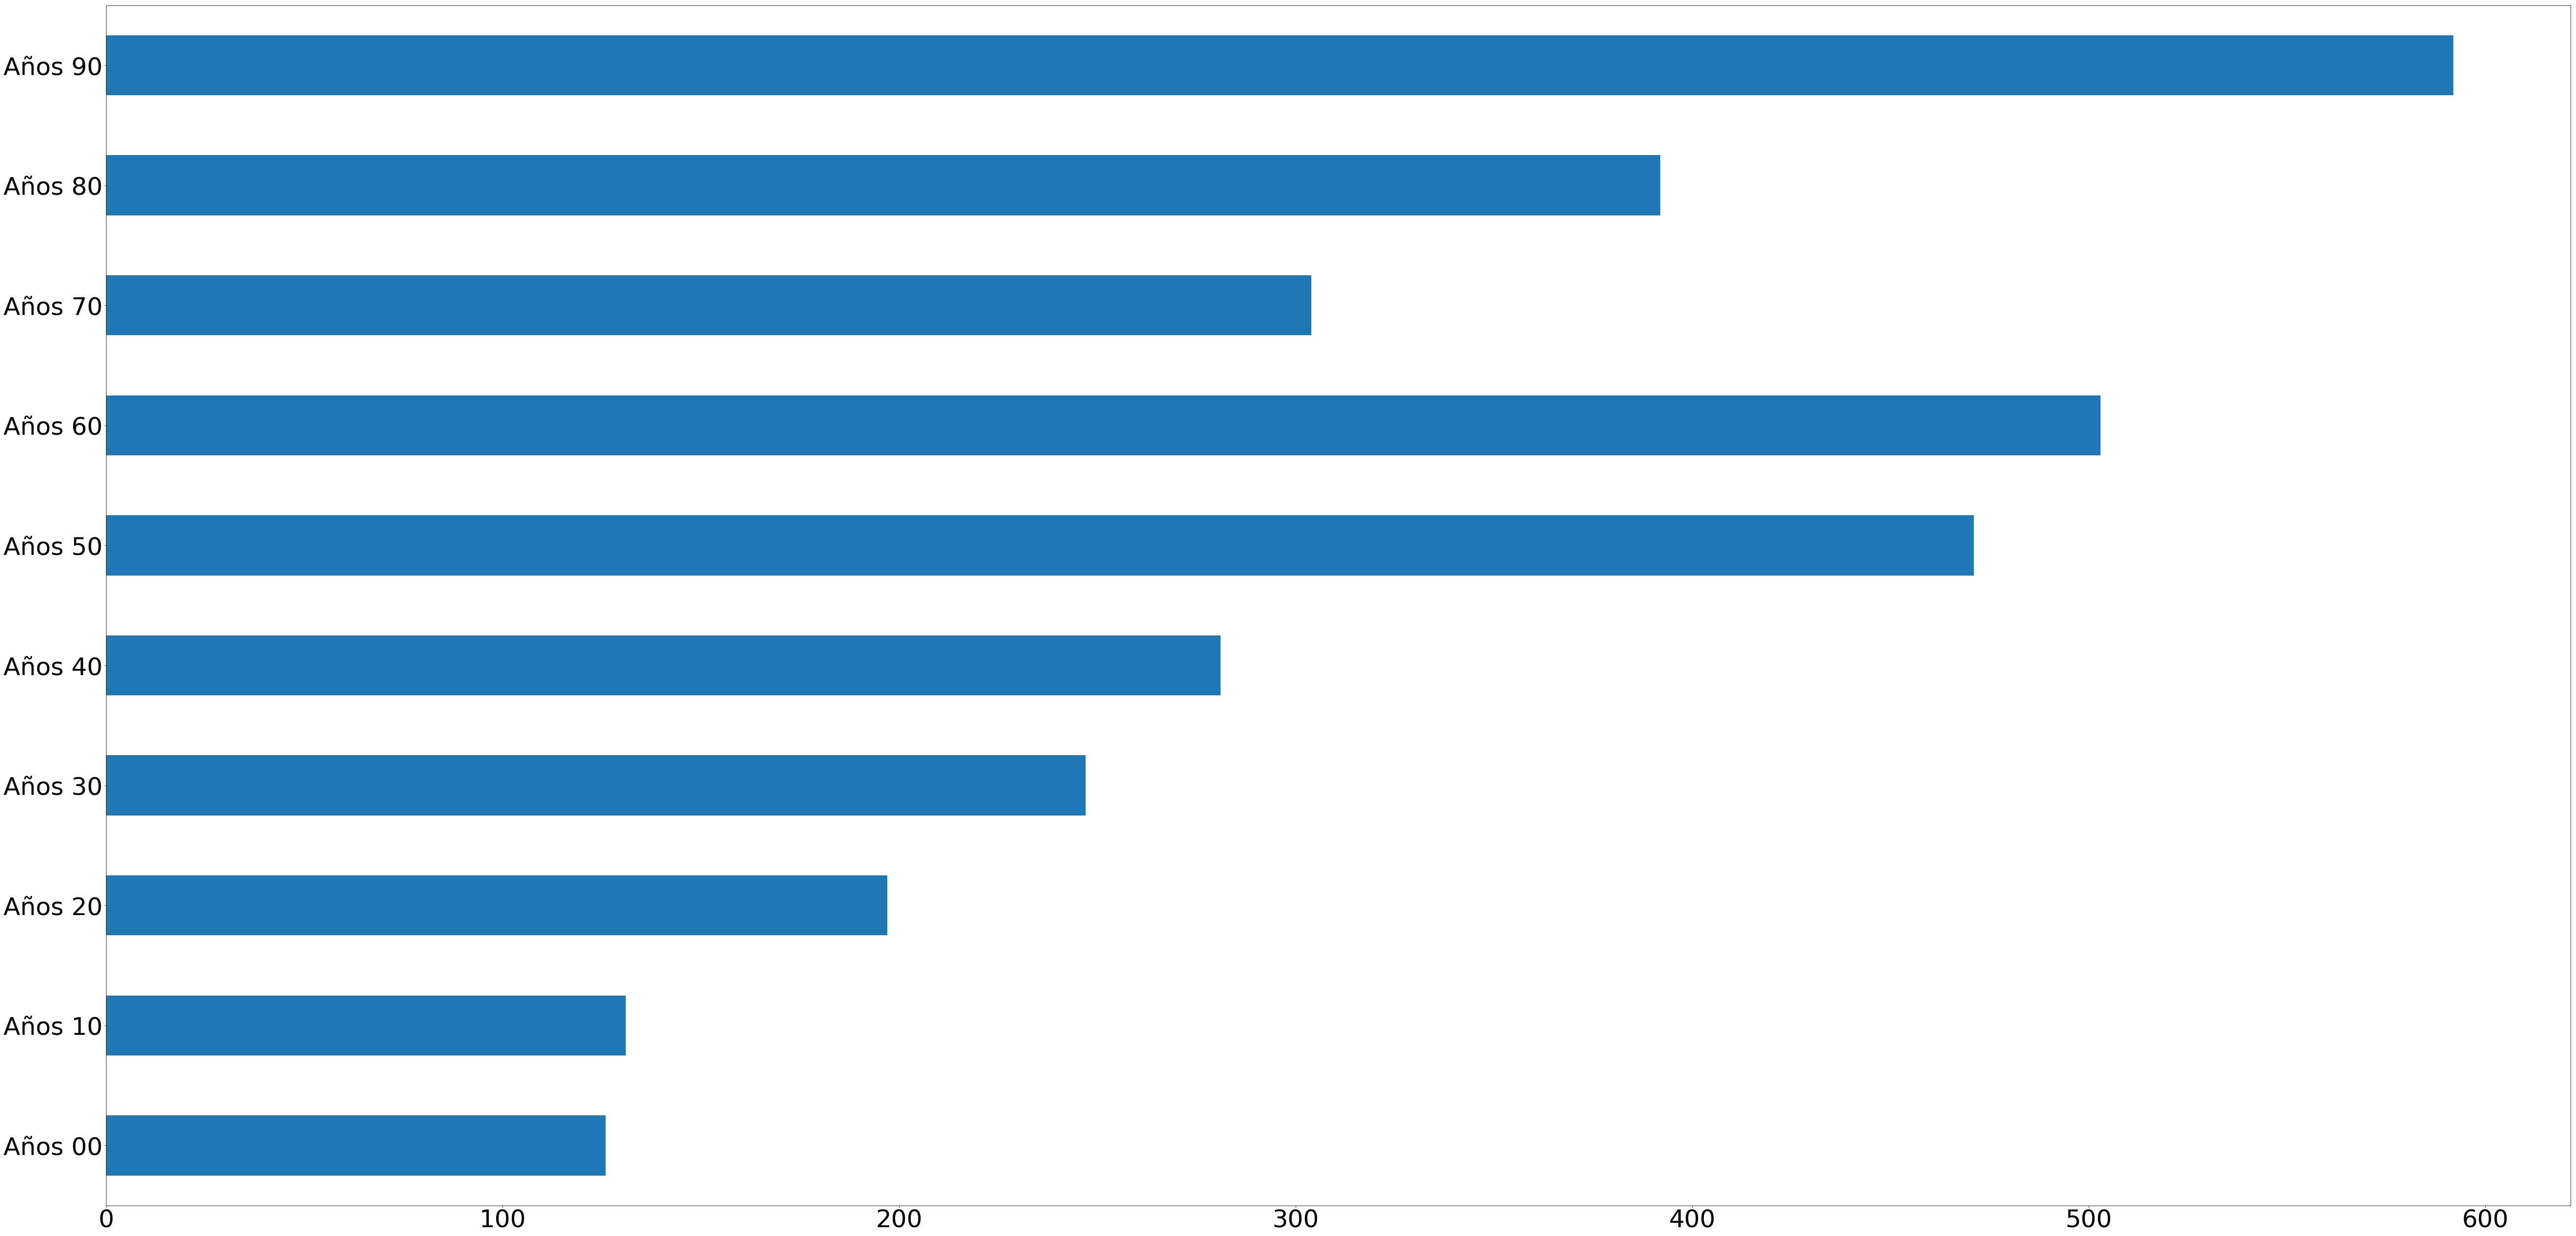

In [30]:
decadas_graf.plot(kind = 'barh', title = '', figsize = (90, 45), fontsize = 50)

In [31]:
datos_siglo.to_csv("datos-ataques-siglo20.csv", index = False)
datos_siglo.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number,Decade
5311,1901,6,Unprovoked,N,M,USA,1901.00.00,Años 00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01,Años 00
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00,Años 00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30,Años 00
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30,Años 00


## Tipos de ataque en el siglo 20

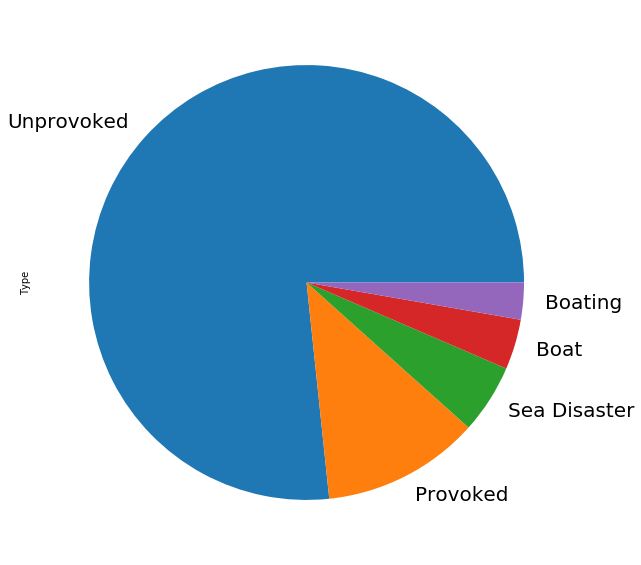

In [32]:
#Tipos de ataque
tipos_ataque = datos_siglo['Type'].value_counts()
tipos_ataque.plot.pie(title = '' , figsize = (10, 10), fontsize = 20 )

## Ataques a hombre y mujeres

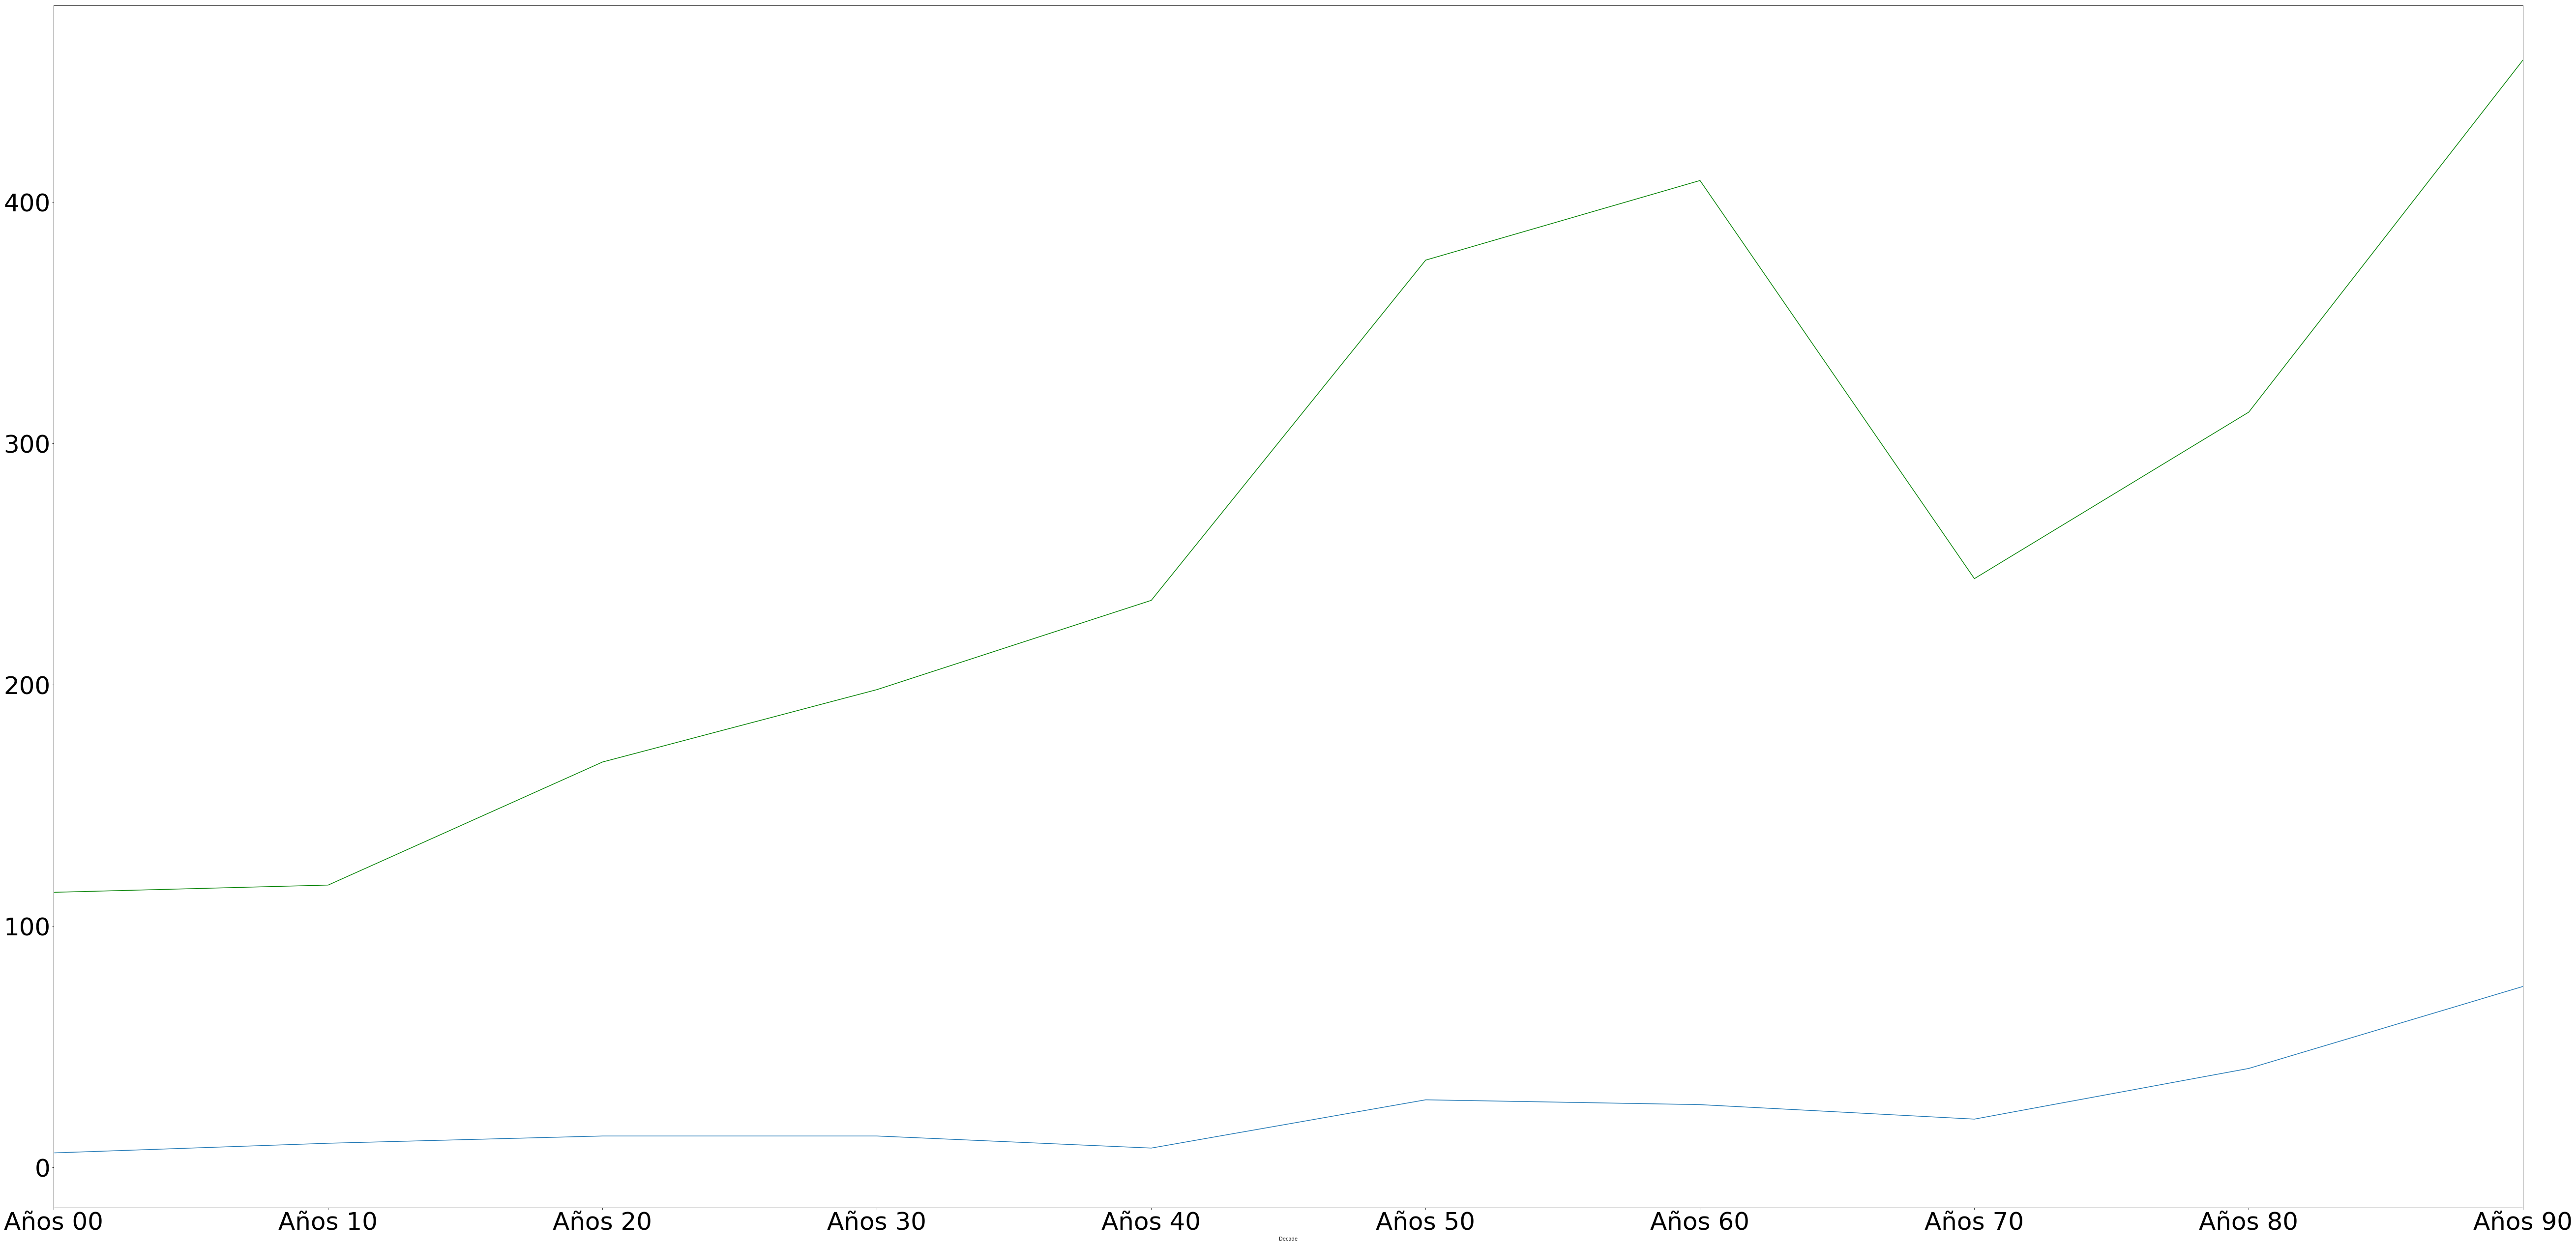

In [33]:
ataques_mujeres = datos_siglo[(datos_siglo.Sex == 'F')].groupby(['Decade']).size()
ataques_hombres = datos_siglo[(datos_siglo.Sex == 'M')].groupby(['Decade']).size()

ataques_mujeres.plot(kind='line',x='name',y='Mujeres', figsize = (90, 45), fontsize = 50)
ataques_hombres.plot(kind='line',x='name',y='Hombres', color='green')


## Ataques en desastre marítimo

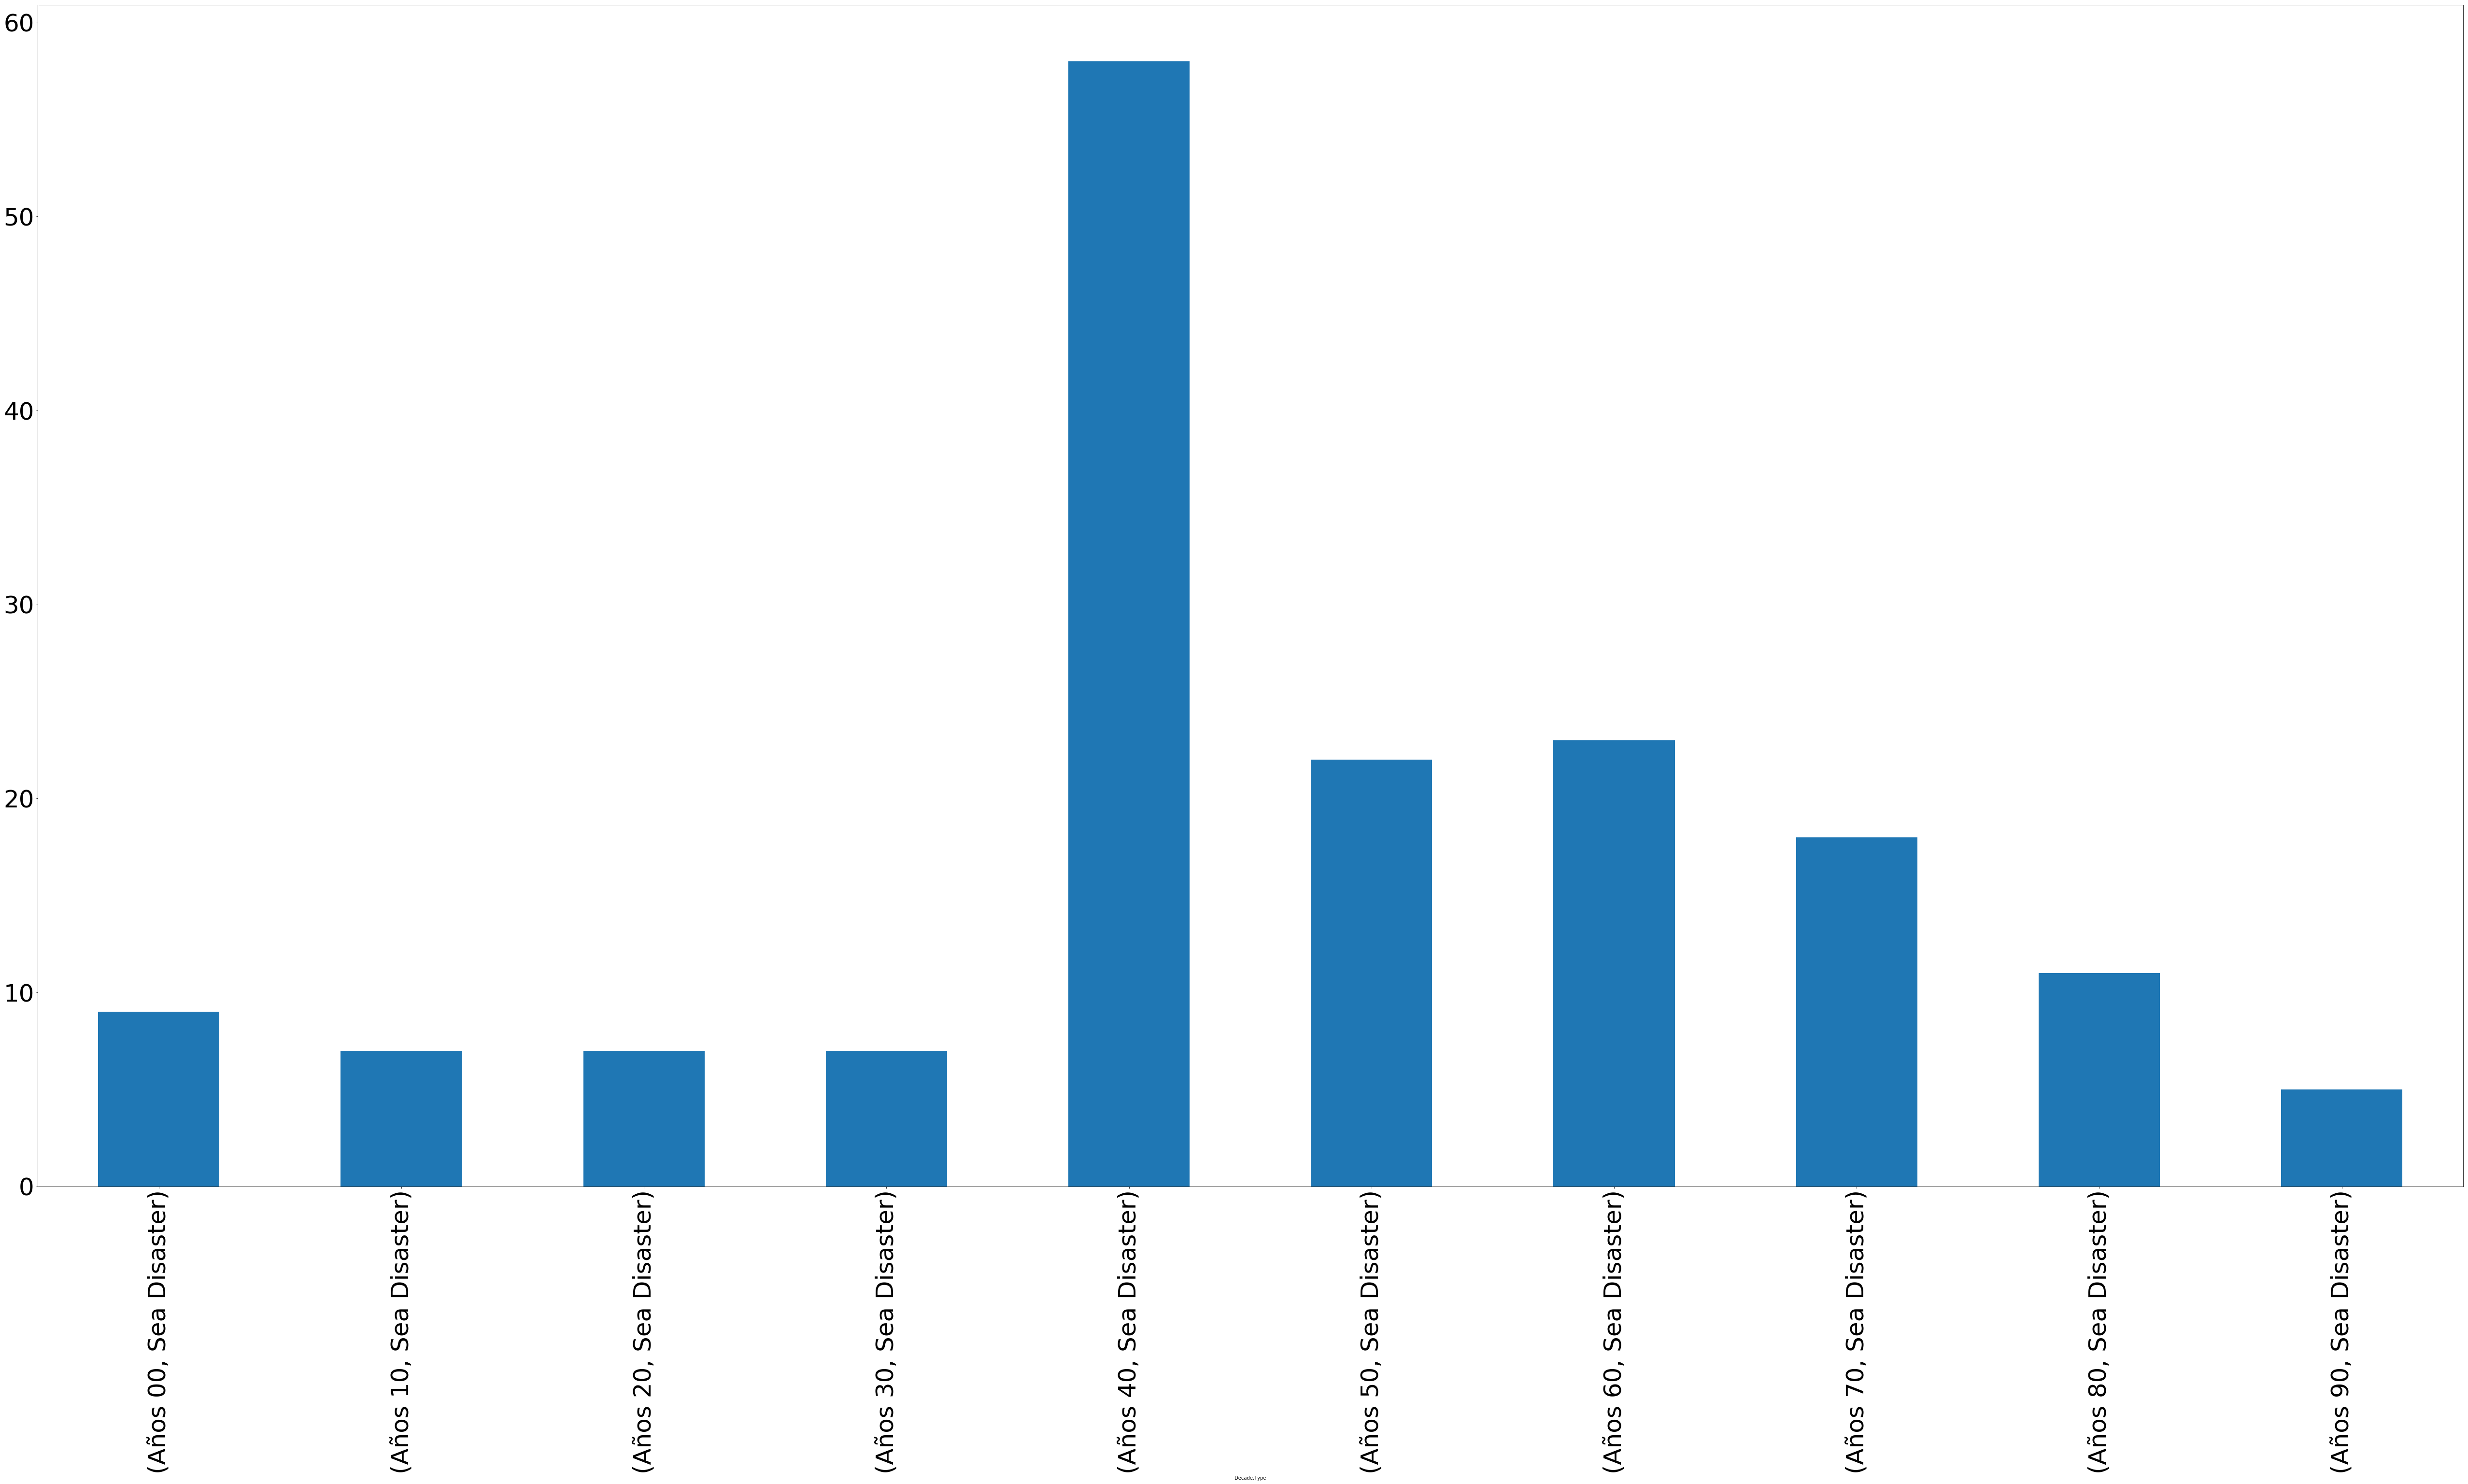

In [34]:
meses_ataques_decada = datos_siglo[(datos_siglo.Type == 'Sea Disaster')].groupby(['Decade', 'Type']).size()
#print(meses_ataques_decada)
meses_ataques_decada.plot(kind = 'bar', title = '', figsize = (90, 45), fontsize = 50)

## Ataque a mujeres 

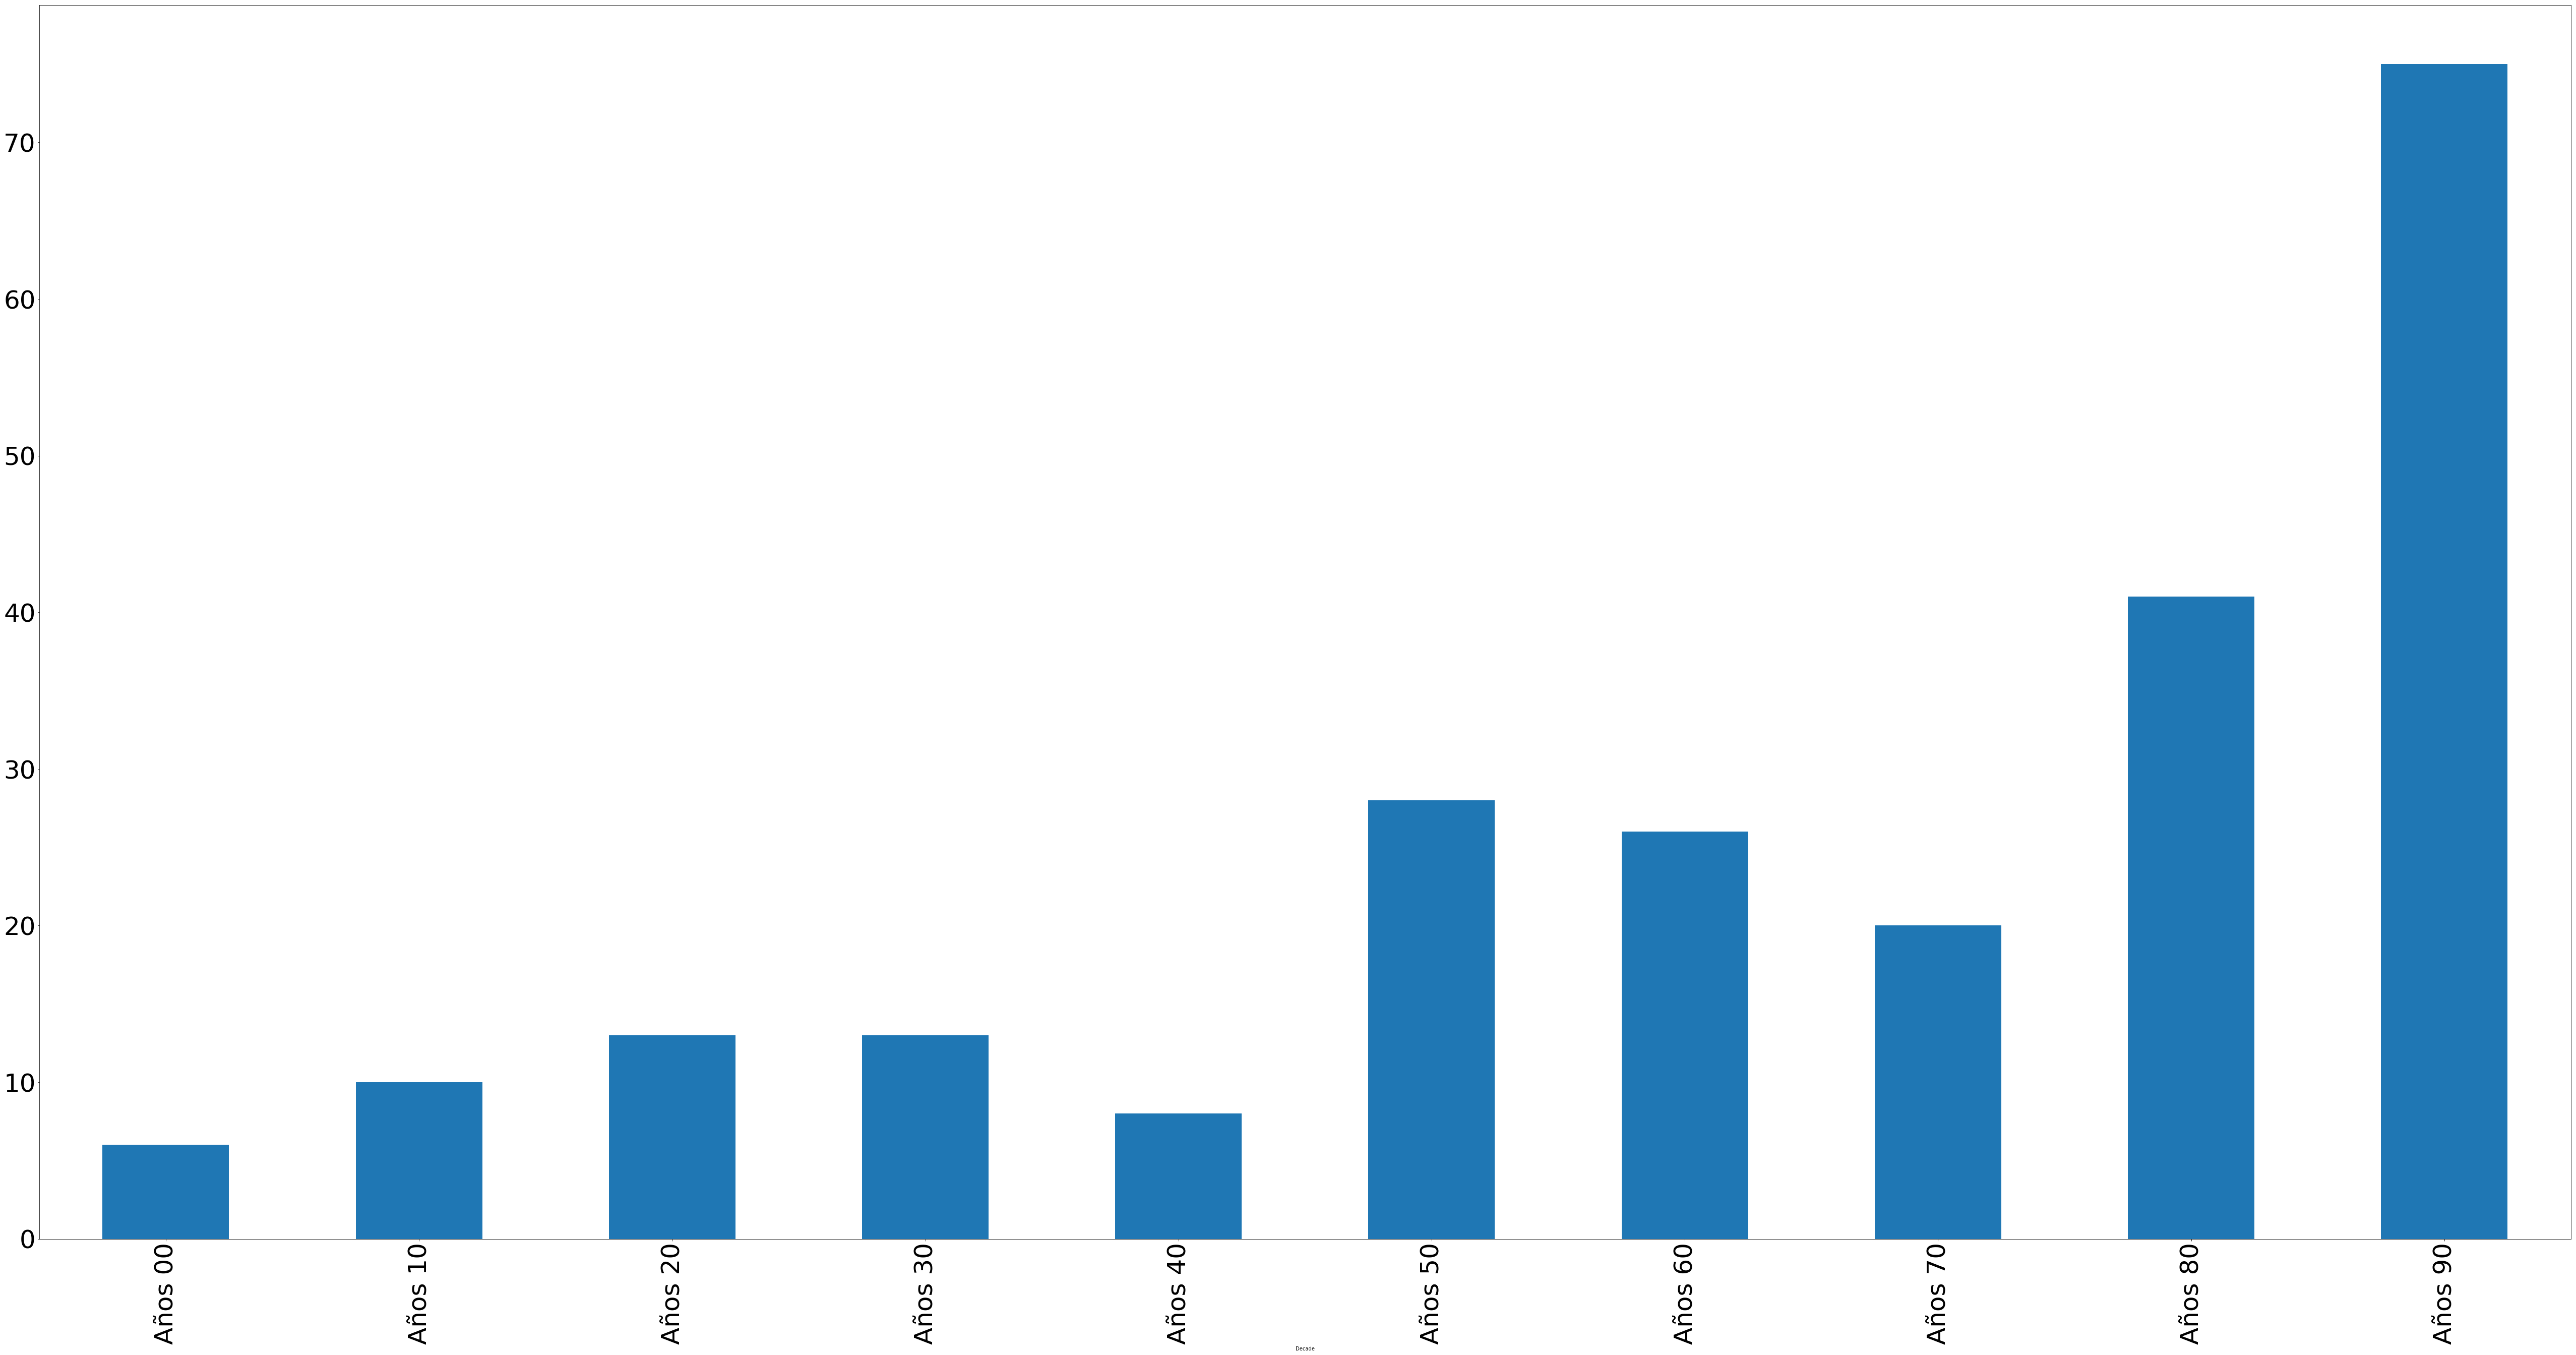

In [35]:
ataques_mujeres = datos_siglo[(datos_siglo.Sex == 'F')].groupby(['Decade']).size()
ataques_mujeres.plot(kind = 'bar', title = '', figsize = (90, 45), fontsize = 50)

## Ataque a hombres

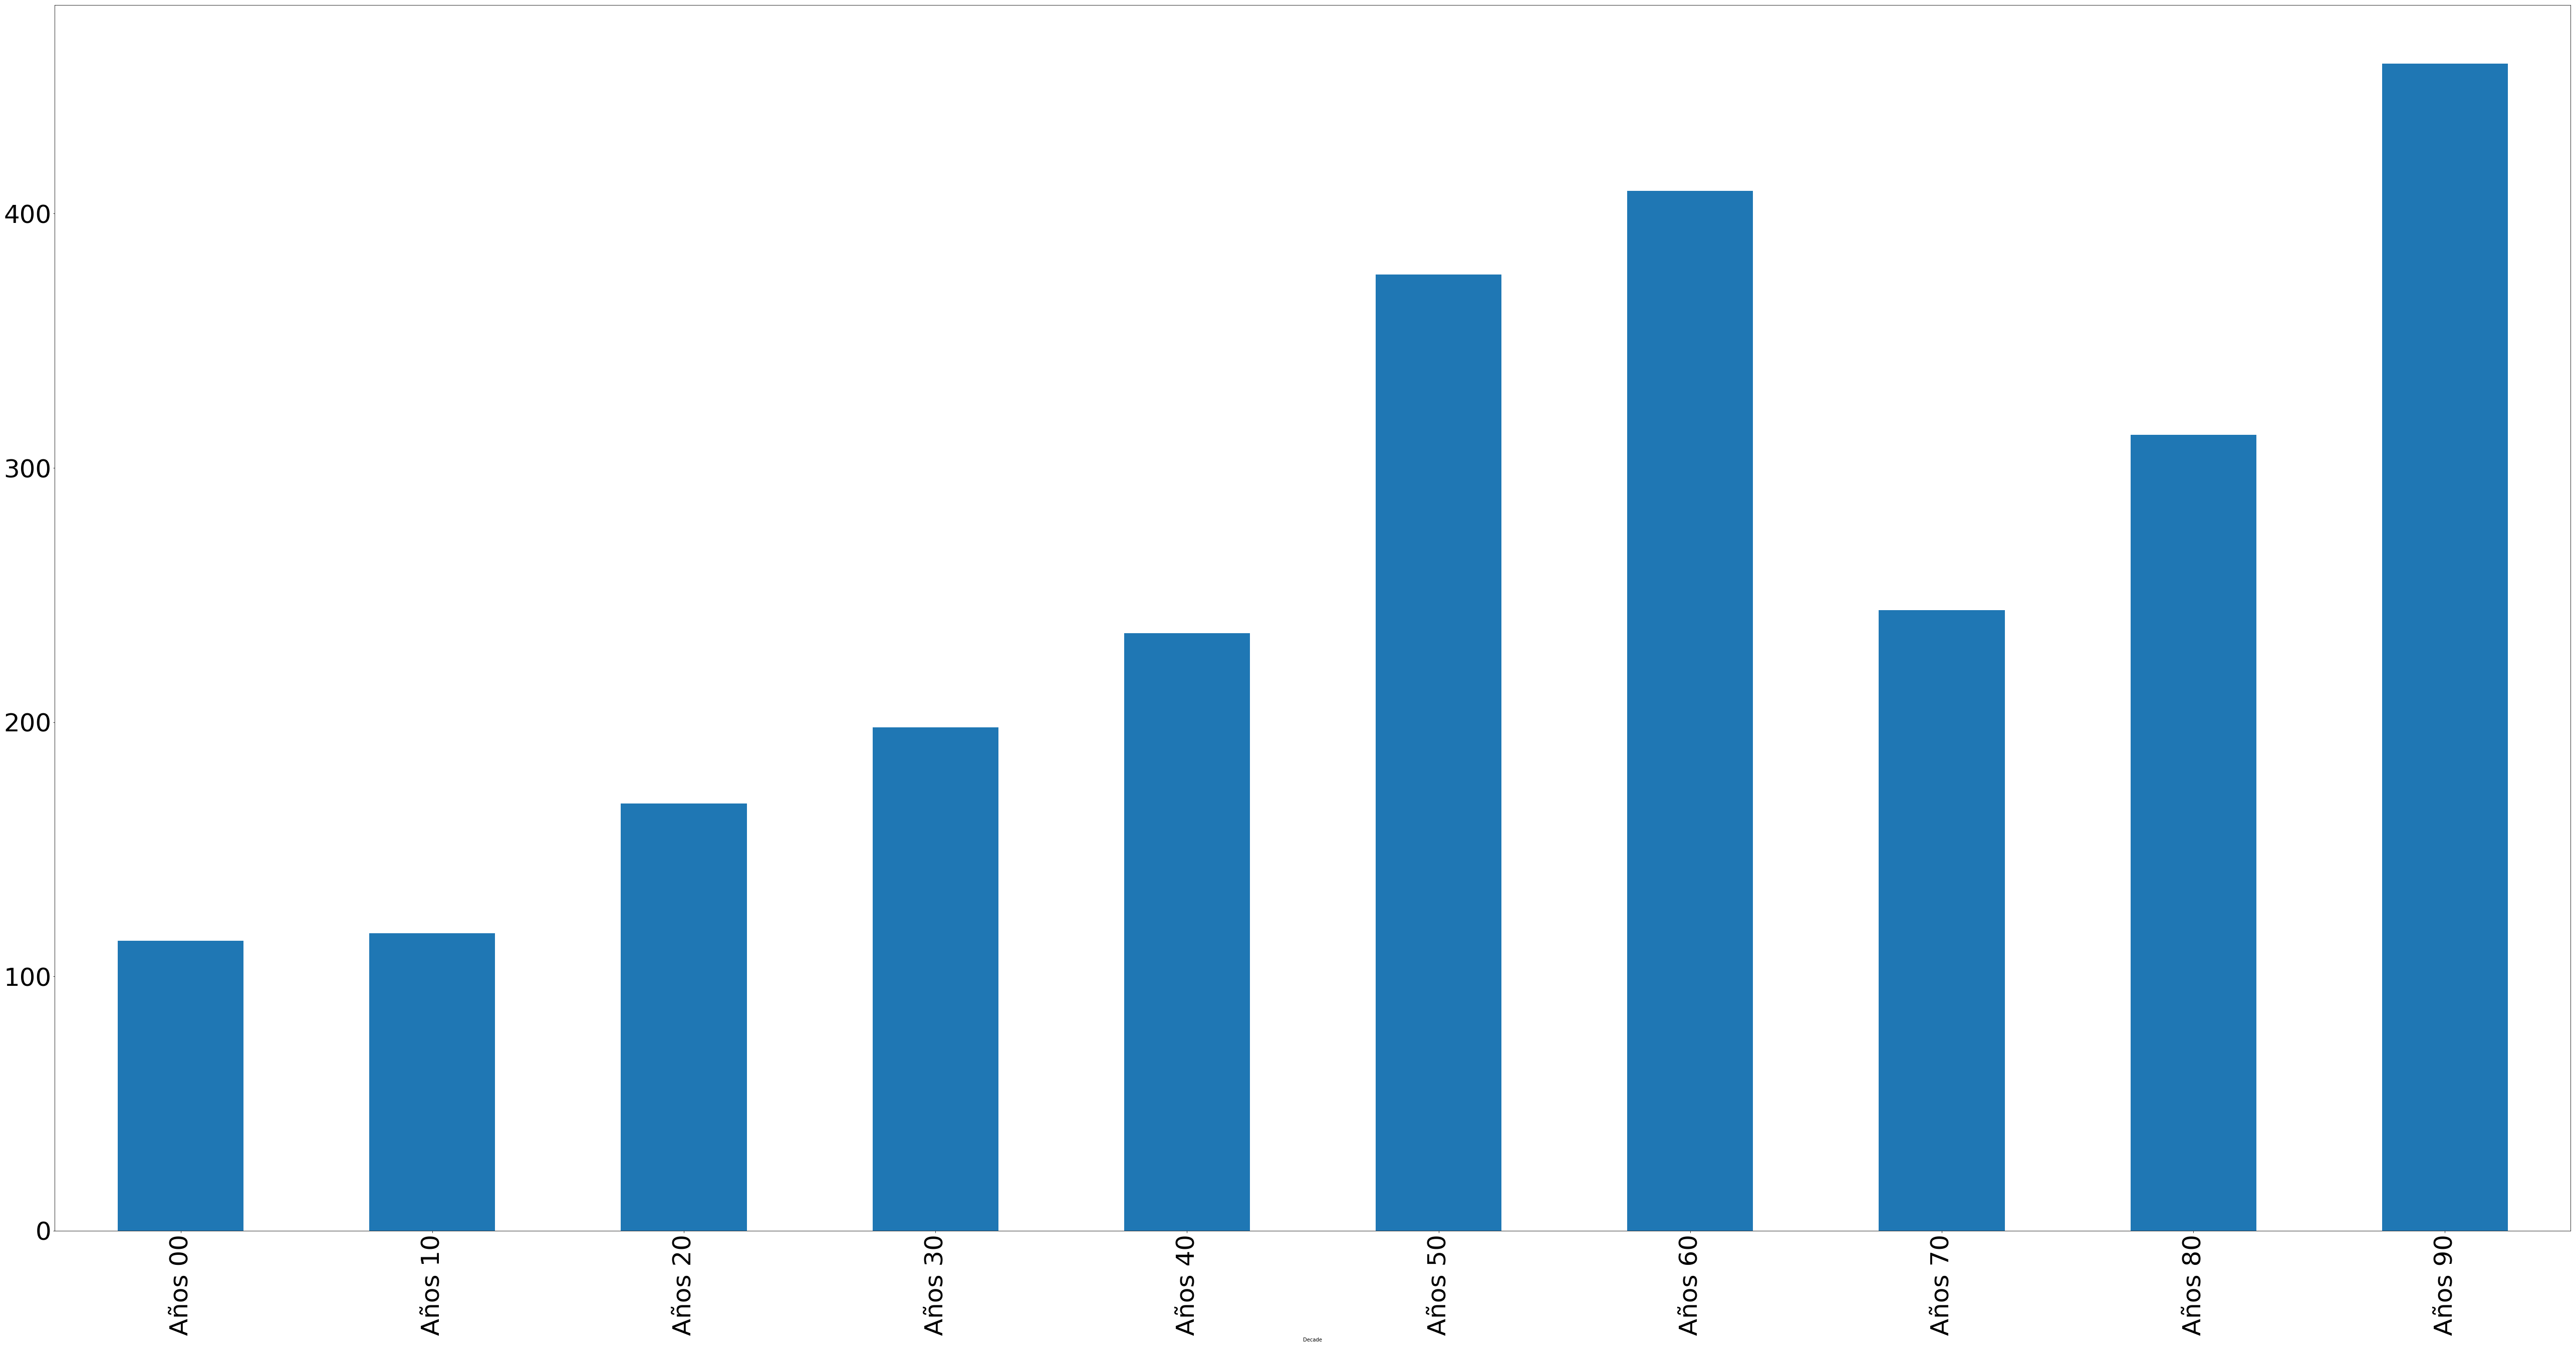

In [36]:
ataques_hombres = datos_siglo[(datos_siglo.Sex == 'M')].groupby(['Decade']).size()
#print(meses_ataques_decada)
ataques_hombres.plot(kind = 'bar', title = '', figsize = (90, 45), fontsize = 50)

## Nivel de muertes entre hombre y mujeres respecto a los ataques

In [38]:
ataques_mujeres_fatales = datos_siglo[(datos_siglo.Sex == 'F') & (datos_siglo.Fatal == 'Y')].groupby(['Decade']).size()

mujeres = (ataques_mujeres_fatales.sum() * 100) / ataques_mujeres.sum()
print('Mujeres {:.2f} %:'.format(mujeres) )

ataques_hombres_fatales = datos_siglo[(datos_siglo.Sex == 'M') & (datos_siglo.Fatal == 'Y')].groupby(['Decade']).size()

hombres = (ataques_hombres_fatales.sum() * 100) / ataques_hombres.sum()
print('Hombres {:.2f} %:'.format(hombres) )

Mujeres 29.17 %:
Hombres 26.51 %:


## Resultado
Aunque las cifras de ataques a mujeres respecto al de hombres son bajas se ha podido demostrar que los ataques a mujeres han ido en aumento durante el avance del siglo.
También que el porcentaje de muertes de mujeres por ataque de tiburón es mayor que el de hombres.

En terminos generales han aumentado los ataques conforme iba avanzando el siglo, durante la decada de los 50 y 60 
hubo un gran aumento de ataques que luego volvio a bajar y posteriormente en los 90 volviera a incrementarse siendo esta la década donde más ataques hubo. 